In [2]:
!nvidia-smi

Sat Nov 30 10:05:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
#Cloning yolov5 repository
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 28 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.68 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (11714/11714), done.


In [4]:
%cd yolov5

/content/yolov5


In [8]:
#Installing dependcies
!pip install -qr requirements.txt
import torch

from IPython.display import Image,clear_output

print("Setup complete. Using torch %s %s"% (torch.__version__, torch.cuda.get_device_properties(0) if
                                            torch.cuda.is_available() else 'cpu'))

Setup complete. Using torch 2.5.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=ff6f46bf-08cf-7443-5f8f-32d5a1d697e7, L2_cache_size=4MB)


In [9]:
pwd

'/content/yolov5'

In [11]:
%cd /content

/content


In [15]:
import gdown

url = "https://drive.google.com/file/d/1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61/view?usp=sharing"

file_id = url.split('/')[-2]

prefix = 'https://drive.google.com/uc?/export=download&id='

gdown.download(prefix+file_id)
print("Data Downloaded")

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61&confirm=t&uuid=e6aa4325-1347-4b01-bac8-eace2a7cff96
To: /content/waste-detection.zip
100%|██████████| 40.1M/40.1M [00:00<00:00, 53.7MB/s]

Data Downloaded


In [16]:
!unzip waste-detection.zip
!rm -rf waste-detection.zip

Archive:  waste-detection.zip
  inflating: data.yaml               
   creating: train/
   creating: train/images/
  inflating: train/images/Banana_10_jpg.rf.7c0536bc9eb72ec77c8f515653f44fb9.jpg  
  inflating: train/images/Banana_11_jpg.rf.188551ec3d51326e5562675d285d0e6a.jpg  
  inflating: train/images/Banana_12_jpg.rf.2ecabc9628a9611963e4804d13045377.jpg  
  inflating: train/images/Banana_12_jpg.rf.e951f9b4b66c9896ce6b7a56f9d41438.jpg  
  inflating: train/images/Banana_15_jpg.rf.09c5d34e95e0c06a808a99533e8e737c.jpg  
  inflating: train/images/Banana_15_jpg.rf.c2909c26fa3140f1734b451bead6752b.jpg  
  inflating: train/images/Banana_15_jpg.rf.e7fb3723604fb753bdbca26f382d7aaf.jpg  
  inflating: train/images/Banana_16_jpg.rf.504aa1c1679f9d595e336eba25f6d80c.jpg  
  inflating: train/images/Banana_16_jpg.rf.73833169c2979508c979f27bcb572959.jpg  
  inflating: train/images/Banana_16_jpg.rf.bd09b3cf6ae33d668a421a48b8c4b34b.jpg  
  inflating: train/images/Banana_16_jpg.rf.dbfad378a52e84709bbb24

In [17]:
import yaml
with open('data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

In [18]:
num_classes

'13'

In [19]:
%cat "/content/yolov5/models/yolov5s.yaml"

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [20]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

In [24]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [23]:
%pwd

'/content'

# Training Yolo V5

In [25]:
%%time

%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 200 --data "/content/data.yaml"  --cfg ./models/custom_yolov5s.yaml --weights "yolov5s.pt" --name yolov5s_results --cache

Streaming output truncated to the last 5000 lines.
    158/199      1.99G    0.02071    0.01146   0.009603         45        416:  91% 53/58 [00:12<00:00,  6.02it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    158/199      1.99G    0.02075    0.01149   0.009636         49        416:  93% 54/58 [00:12<00:00,  5.48it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    158/199      1.99G    0.02085    0.01152   0.009591         57        416:  95% 55/58 [00:12<00:00,  5.43it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
    158/199      1.99G    0.02086    

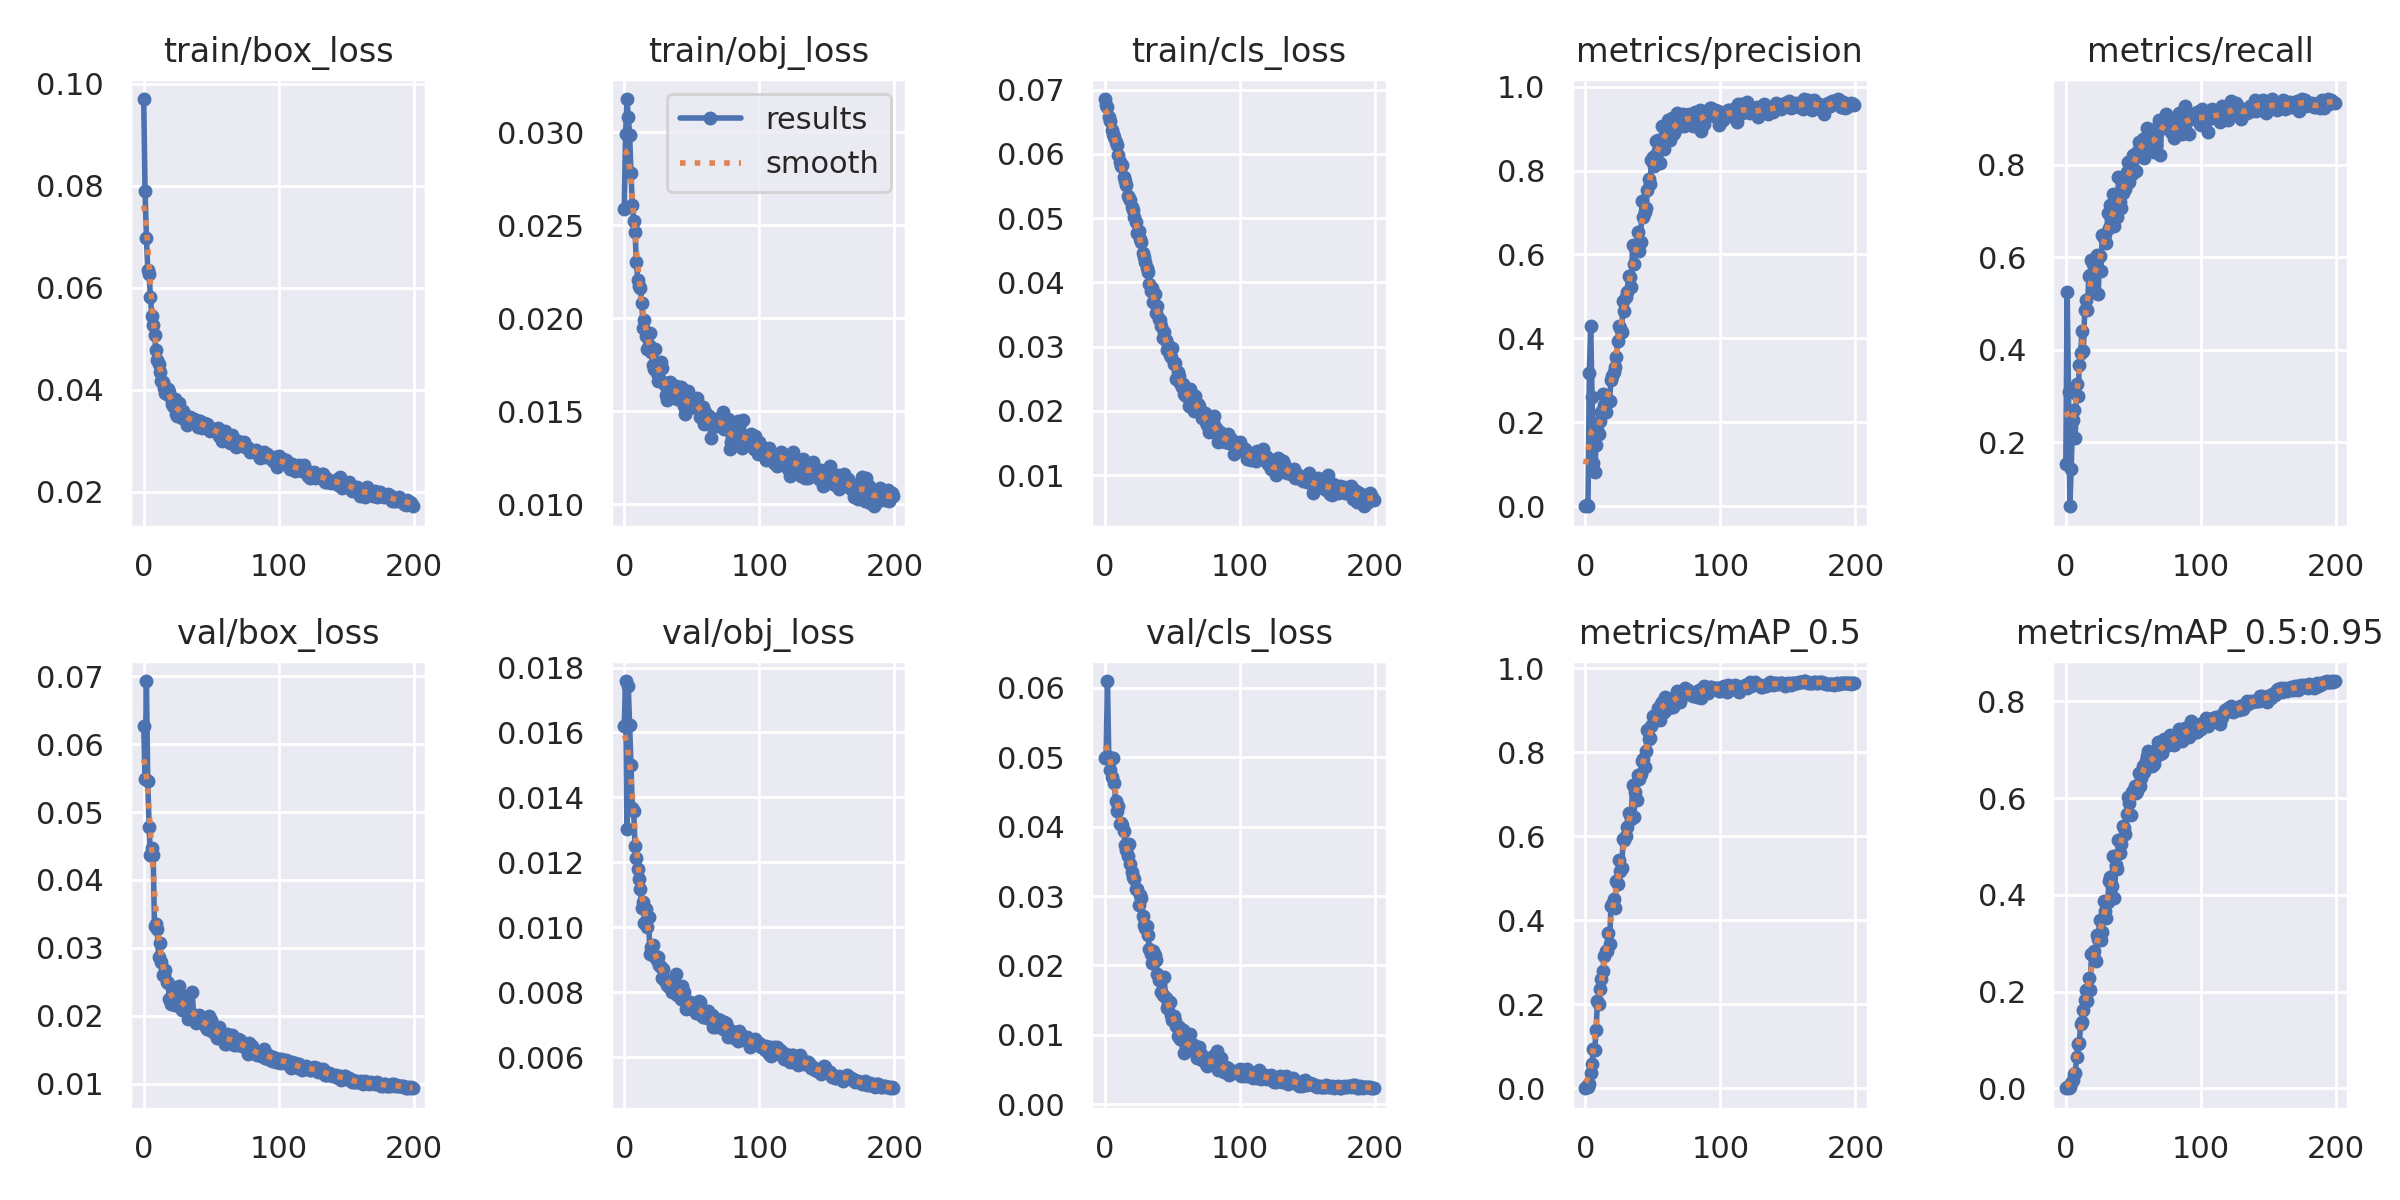

In [26]:
from utils.plots import plot_results
Image(filename = "/content/yolov5/runs/train/yolov5s_results/results.png",width = 1000)

Ground Truth Augemented Data 


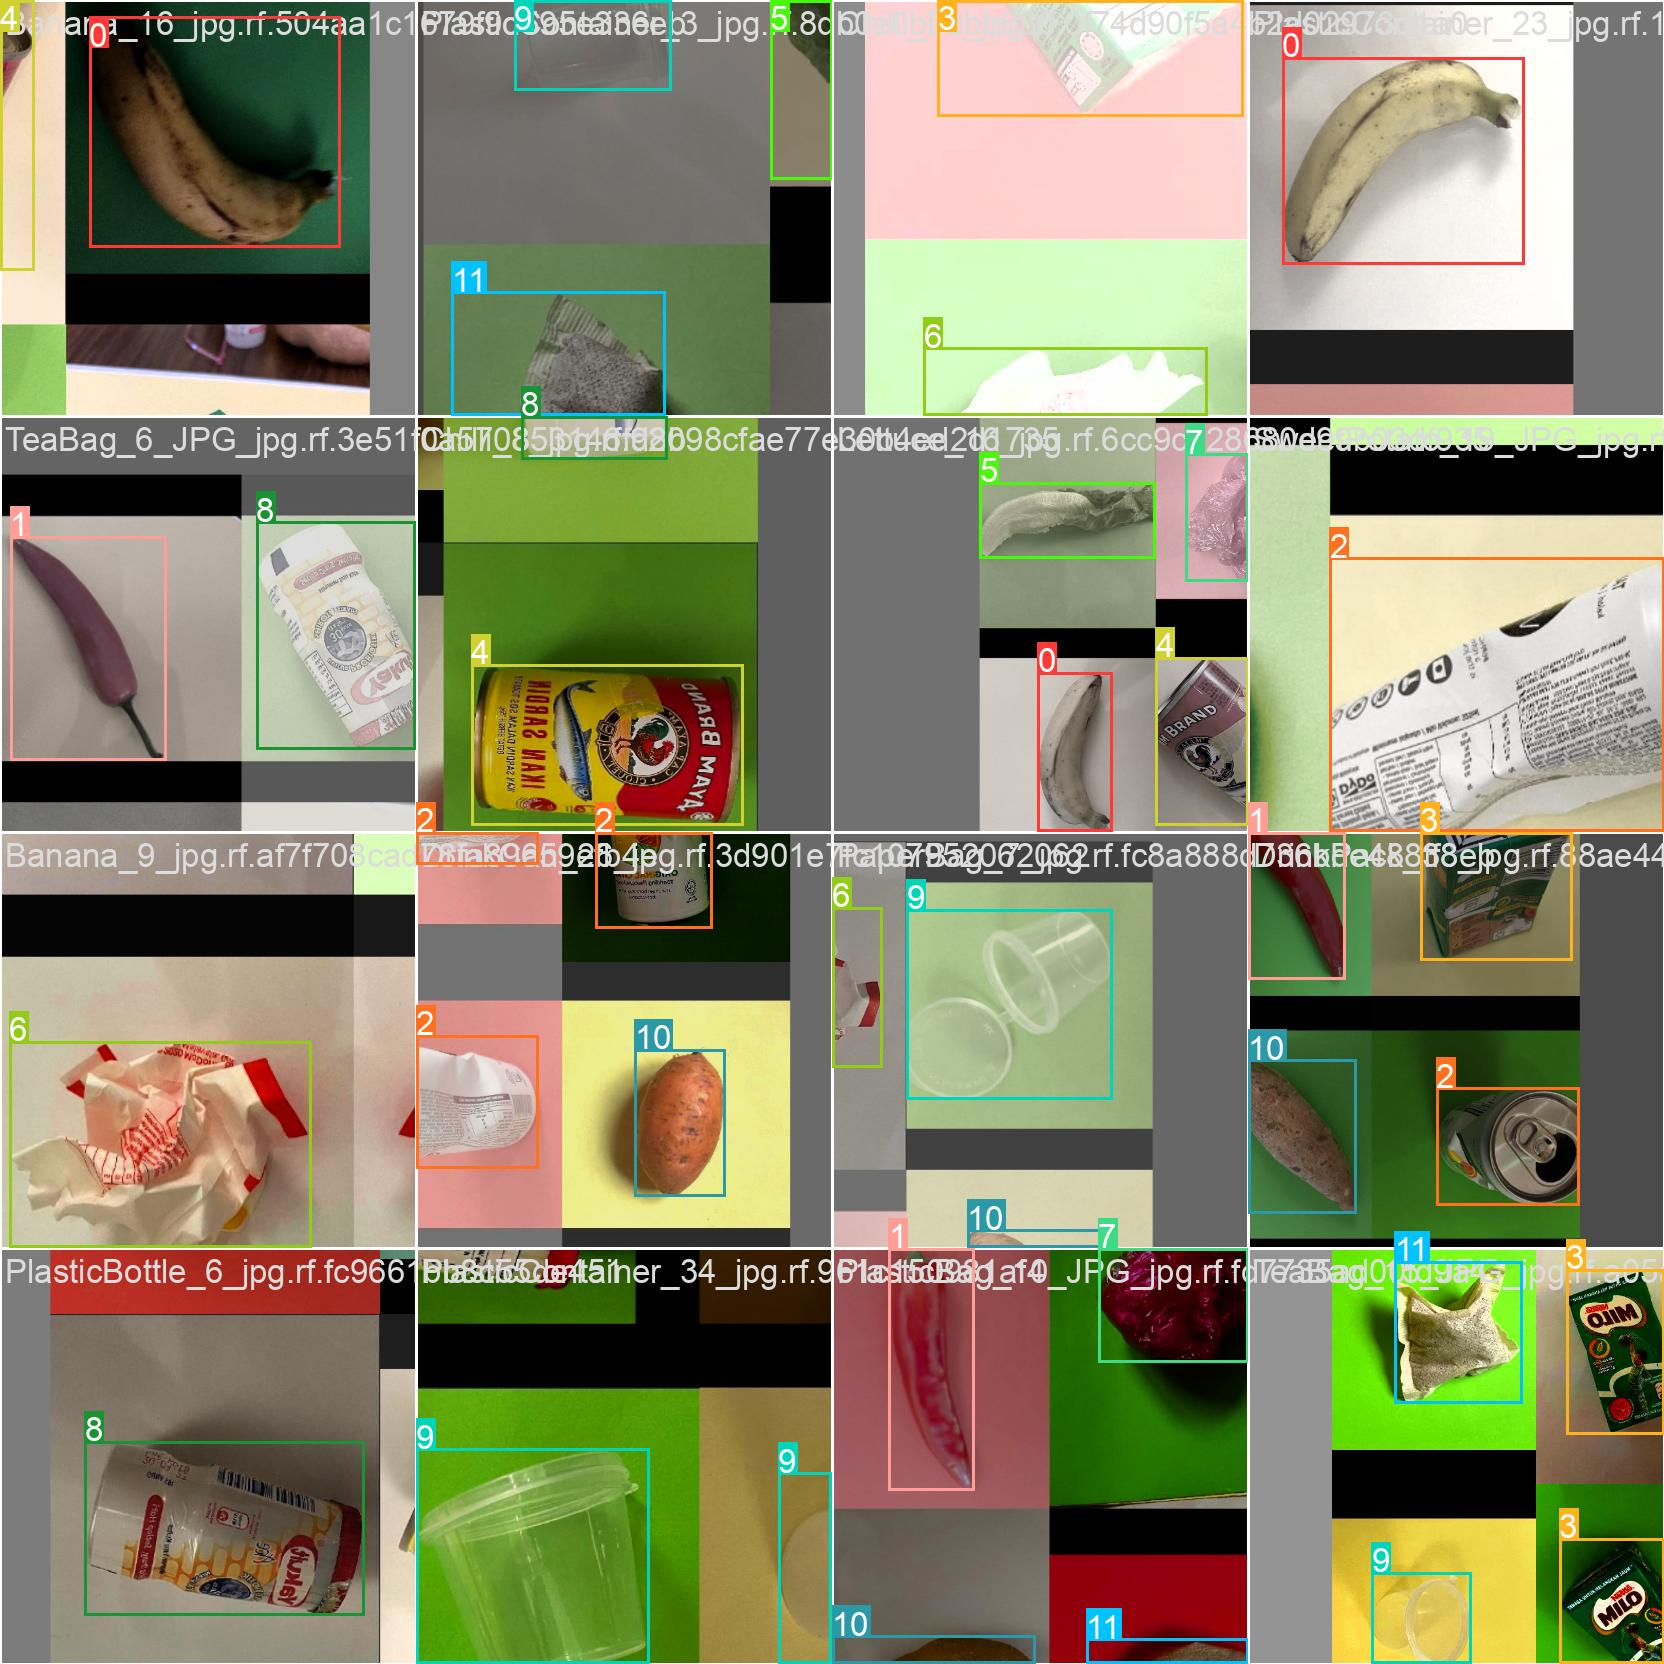

In [28]:
print("Ground Truth Augemented Data ")
Image(filename="/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg",width=1000)

In [29]:
# Making detection using the trained model
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source /content/valid/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7278882 parameters, 0 gradients
image 1/459 /content/valid/images/Banana_10_jpg.rf.0f4f5f5b749f5681048000d59b667d94.jpg: 416x320 1 banana, 31.5ms
image 2/459 /content/valid/images/Banana_10_jpg.rf.5d587c81371bd16a3a5eba3af30ce089.jpg: 416x320 1 banana, 6.8ms
image 3/459 /content/valid/images/Banana_11_jpg.rf.4db17dd5278

# Export Trained Weights for future Inference

In [31]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [32]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/MyDrive/Yolo_models